In [290]:
import sys
import numpy as np
import pandas as pd
from radio import batchflow as ds
from radio import CTImagesMaskedBatch as CTIMB
from radio.pipelines import combine_crops
from radio.models import Keras3DUNet
from radio.models.keras.losses import dice_loss
from radio.models.tf.losses import tversky_loss
from tqdm import tqdm


In [291]:
nodules = pd.read_csv('D:\\Users\\mrm27\\Documents\\data\\annotations.csv')

# create index and dataset
lunaix = ds.FilesIndex(path='D:\\Users\\mrm27\\Documents\\data\\luna\\subset2\\*.mhd', no_ext=True)
lunaset = ds.Dataset(index=lunaix, batch_class=CTIMB)
lunaset.split(0.9, shuffle=True)
print(len(lunaset.train))

21


In [292]:
from radio.pipelines import split_dump

In [293]:
SPACING = (1.7, 1.0, 1.0)  # spacing of scans after spacing unification
SHAPE = (400, 512, 512)  # shape of scans after spacing unification
PADDING = 'reflect'  # 'reflect' padding-mode produces the least amount of artefacts
METHOD = 'pil-simd'  # robust resize-engine

kwargs_default = dict(shape=SHAPE, spacing=SPACING, padding=PADDING, method=METHOD)

crop_pipeline = split_dump(cancer_path='D:\\Users\\mrm27\\Documents\\data\\lunaset_split\\cancer\\',
                    non_cancer_path='D:\\Users\\mrm27\\Documents\\data\\lunaset_split\\noncancer\\',
                    nodules=nodules, fmt='raw', nodule_shape=(32, 64, 64),
                    batch_size=20, **kwargs_default)

In [294]:
(lunaset.train >> crop_pipeline).run()

In [295]:
# Todo: Pre data
DIR_CANCER = 'D:\\Users\\mrm27\\Documents\\data\\lunaset_split\\cancer\\*'
DIR_NCANCER = 'D:\\Users\\mrm27\\Documents\\data\\lunaset_split\\noncancer\\*'
train_time = 1
my_epoch = 1
bs = 5
loss_his = []
cix = ds.FilesIndex(path=DIR_CANCER, dirs=True)
ncix = ds.FilesIndex(path=DIR_NCANCER, dirs=True)
cancerset = ds.Dataset(index=cix, batch_class=CTIMB)
ncancerset = ds.Dataset(index=ncix, batch_class=CTIMB)

In [296]:
from utils import *

In [643]:
combine_pipeline = combine_crops(cancerset, ncancerset, batch_sizes=(20, 1))

batch = combine_pipeline.next_batch()

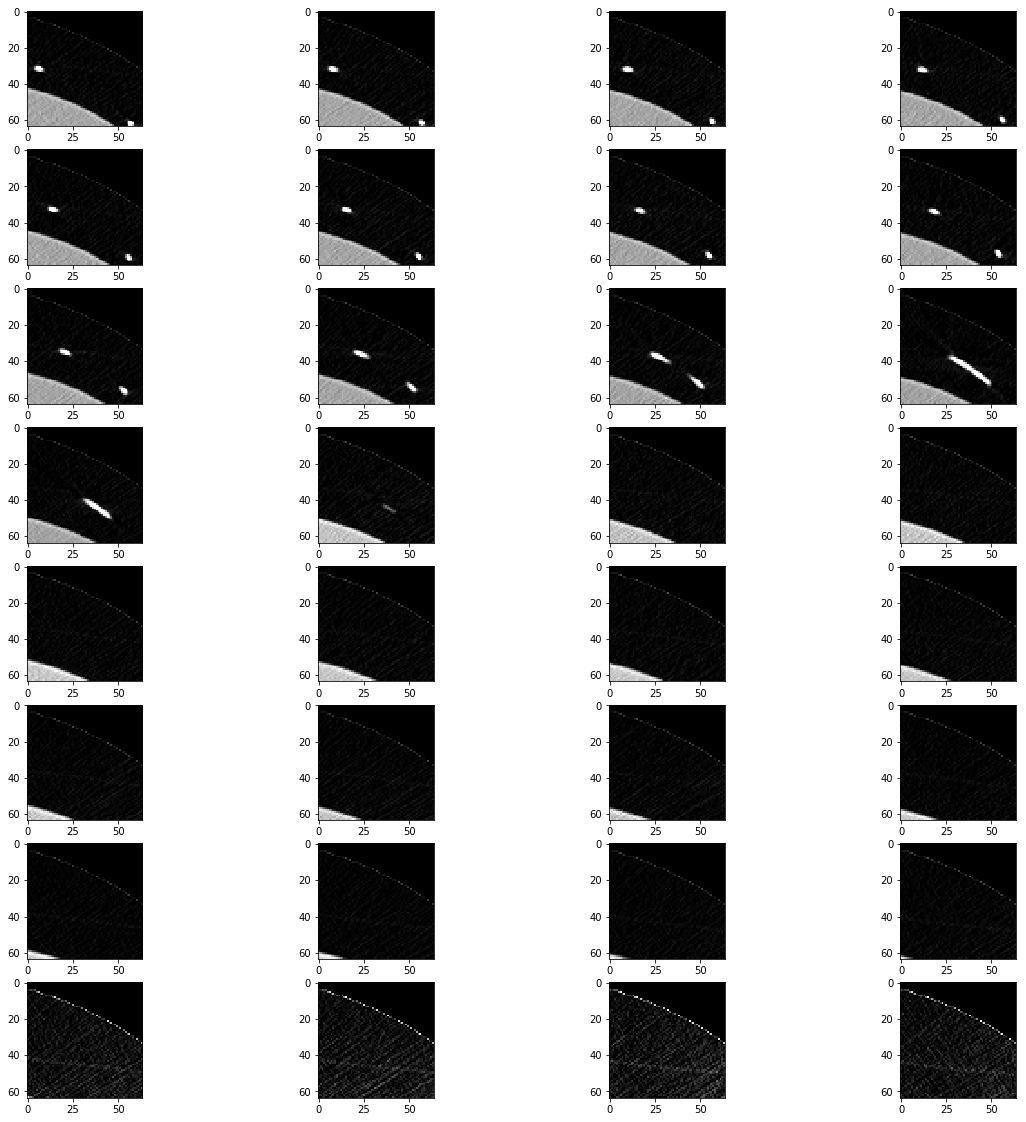

In [644]:
x= batch.unpack()
fig=plt.figure(figsize=(20,20))
columns = 4
rows = 8
itr = 0
for i in range(1, columns*rows +1):
    img = x[0,itr,:,:]
    itr = itr + 1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

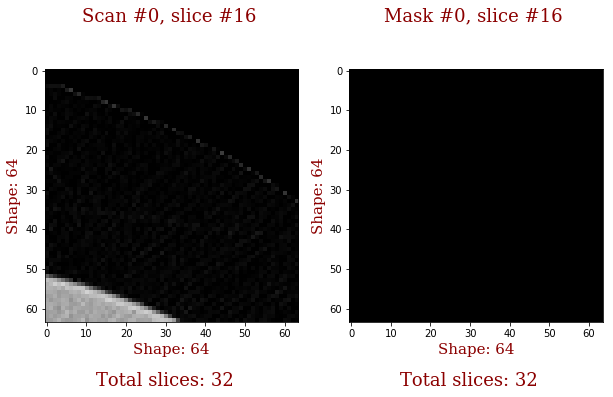

In [645]:
show_slices(batch, scan_indices=0, ns_slice=16, clims=[(0, 255), (0, 1)],
            components=('images', 'masks'), grid=False)

In [604]:
# Todo: Build & Trian model
unet_config = dict(
    input_shape=(1, 32, 64, 64),
    num_targets=1,
    loss=dice_loss)


In [301]:
from radio.batchflow import F, V
from IPython.display import clear_output

In [302]:
train_unet_pipeline = (
    combine_crops(cancerset, ncancerset, batch_sizes=(bs, bs))
    .init_variable('loss_acc', 0)
    .init_variable('current_loss', 0)
    .init_variable('loss_history', init_on_each_run=list)
    .init_variable('cancer_len', len(cancerset))
    .init_variable('ncancer_len', len(ncancerset))
    .init_model(
        name='3dunet', model_class=Keras3DUNet,
        config=unet_config, mode='static'
    )
    .train_model(
        name='3dunet', fetches=[V('loss_acc'), V('cancer_len'), V('ncancer_len')], save_to=V('loss_acc'),
        x=F(CTIMB.unpack, component='images', data_format='channels_first'),
        y=F(CTIMB.unpack, component='masks', data_format='channels_first')
    )
    # .run(batch_size=bs, n_epochs=4, drop_last=True, bar=True)
    .print("loss and acc is:", V('loss_acc'))
    .update_variable('loss_history', value=V('loss_acc'), mode='a')
    .call(lambda x: clear_output(wait=True))
    # Notice: here we use train_on_batch to train our model, train_on_batch return 2 metrics ['loss', 'acc'].
)

In [303]:
t = train_unet_pipeline.run(epoch=my_epoch, batch_size=bs)

('loss and acc is:', array(-0.02466826, dtype=float32))


Text(0, 0.5, 'Dice loss')

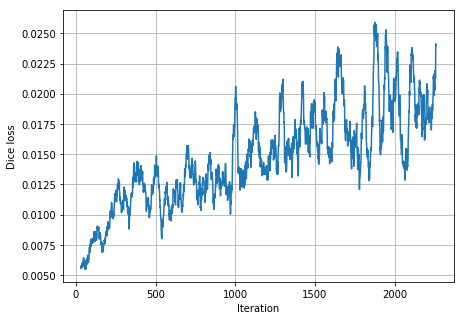

In [634]:
loss_history = (
    pd.Series(train_unet_pipeline.get_variable('loss_history'))
    .rolling(32)
    .mean()
    .transform(lambda x: -x)
)

plt.figure(figsize=(7, 5))
loss_history.plot(grid=True)
plt.xlabel('Iteration')
plt.ylabel('Dice loss')

In [646]:
x=batch.unpack('images')
image = x
print(image.shape)
# image = image[2,:,:,:]
# print(image.shape)
image = np.expand_dims(image, axis=0)
# plt.figure(0,(10,10))
print(image.shape)
image = image[0,0,:,:,:]
print(image.shape)
image = np.expand_dims(image, axis=0)
print(image.shape)
image = np.expand_dims(image, axis=0)
print(image.shape)
# plt.imshow(x[6,10,:,:])

(21, 32, 64, 64)
(1, 21, 32, 64, 64)
(32, 64, 64)
(1, 32, 64, 64)
(1, 1, 32, 64, 64)


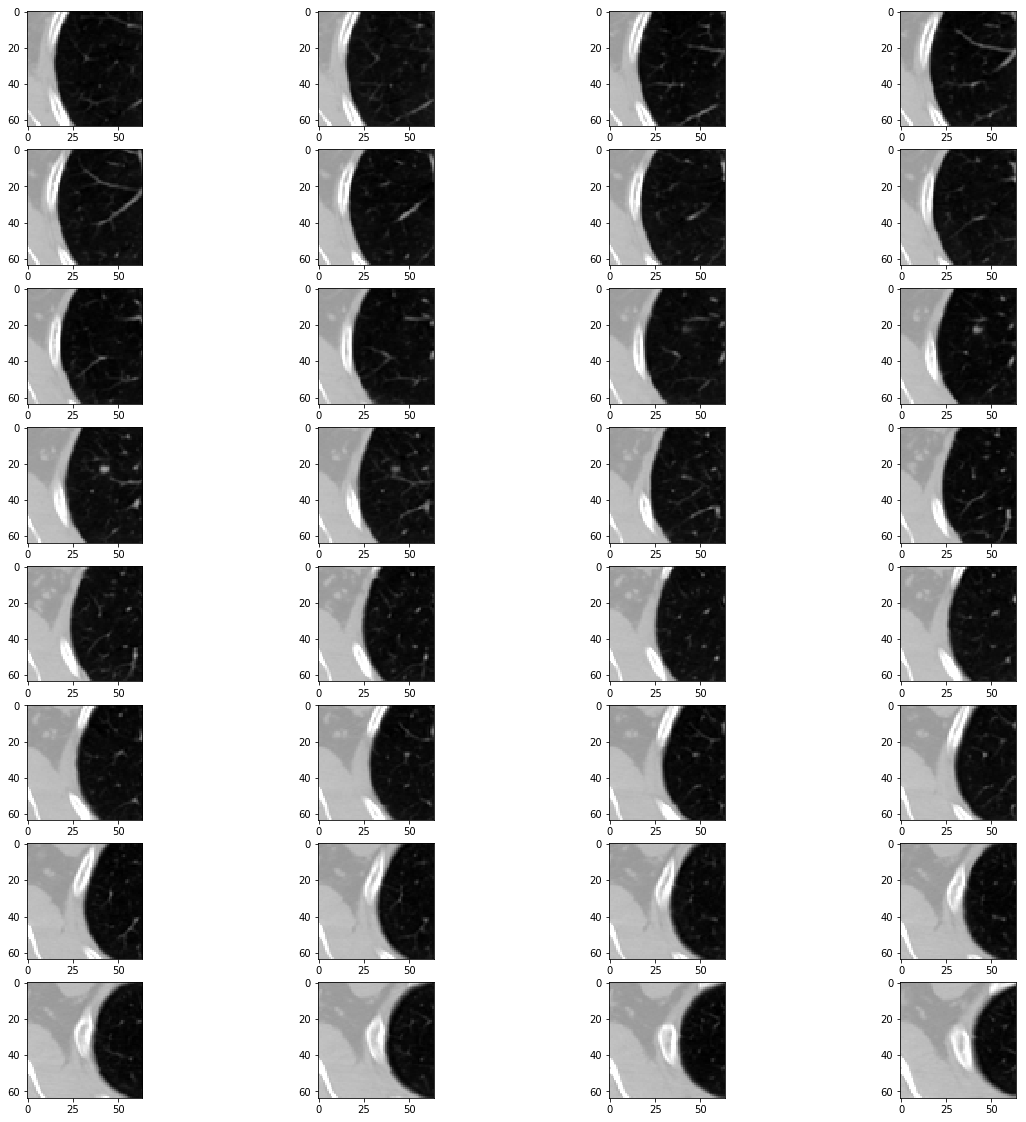

In [647]:
fig=plt.figure(figsize=(20,20))
columns = 4
rows = 8
itr = 0
for i in range(1, columns*rows +1):
    img = x[6,itr,:,:]
    itr = itr + 1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

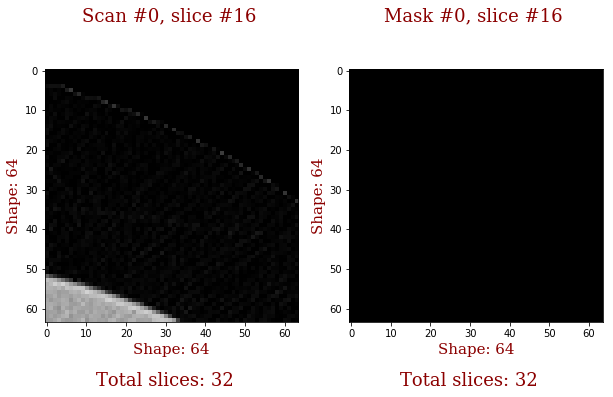

In [648]:
unet_model = train_unet_pipeline.get_model_by_name('3dunet')

predicted_masks = unet_model.predict(image)

show_slices(batch, scan_indices=0, ns_slice=16, clims=[(0, 255), (0, 1)],
            components=('images', 'masks'), grid=False)


In [649]:
# print(predicted_masks.shape)
# batch.masks = predicted_masks.reshape(-1, 64, 64)
# print(batch.masks.shape)

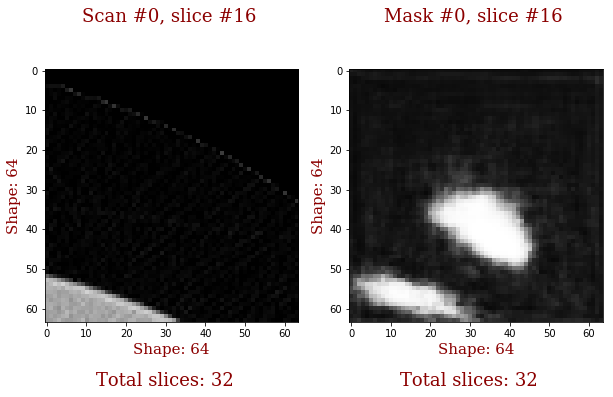

In [650]:
# batch.masks = predicted_masks.reshape(-1, 64, 64)
batch.masks = predicted_masks.reshape(-1, 64, 64)
show_slices(batch, scan_indices=0, ns_slice=16, clims=[(0, 255), (0, 1)],
            components=('images', 'masks'), grid=False)